In [ ]:
# avg.py

import numpy as np

# 기본 구현
np.random.seed(0)  # 시드 고정 // 같은 random 난수 생성기에 국한해 같은 랜덤성을 가지게 해줌! 미래에
rewards = []

for n in range(1, 11):  # 10번 플레이
    reward = np.random.rand()  # 보상(무작위수로 시뮬레이션)
    rewards.append(reward)
    Q = sum(rewards) / n
    print(Q)

print('---')

# 증분 구현
np.random.seed(0)
Q = 0

for n in range(1, 11):
    reward = np.random.rand()
    Q = Q + (reward - Q) / n  # [식 1.5]
    print(Q)


# 즉, 시드를 고정하면 “난수 생성기의 미래”가 완전히 결정됨!

0.5488135039273248
0.6320014351498722
0.6222554154571295
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425
---
0.5488135039273248
0.6320014351498722
0.6222554154571294
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425


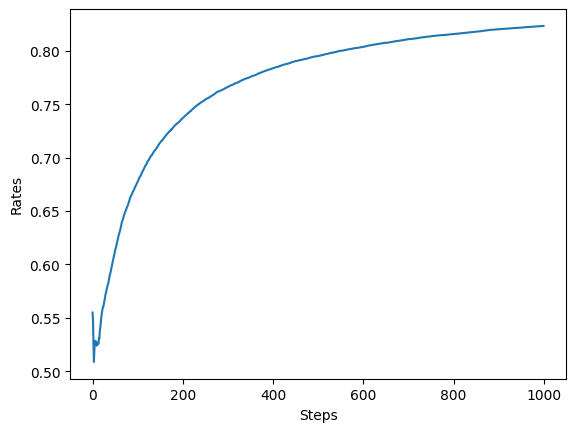

In [2]:
# bandit_avg.py

import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandit, Agent


runs = 200
steps = 1000
epsilon = 0.1
all_rates = np.zeros((runs, steps))  # (200, 1000) 형상 배열

for run in range(runs):  # 200번 실험
    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        total_reward += reward
        rates.append(total_reward / (step + 1))

    all_rates[run] = rates  # 보상 결과 기록

avg_rates = np.average(all_rates, axis=0)  # 각 단계의 평균 저장

# [그림 1-16] 단계별 승률(200번 실험 후 평균)
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show()


869


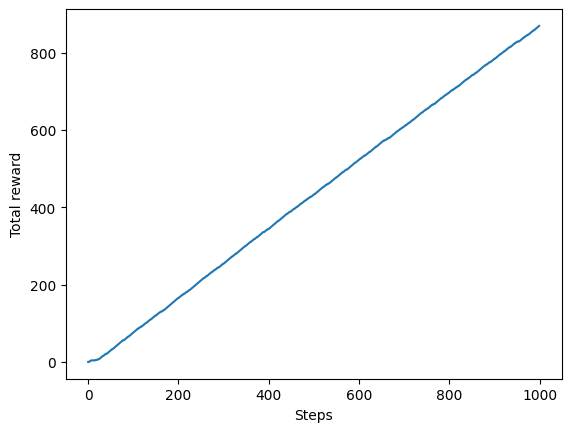

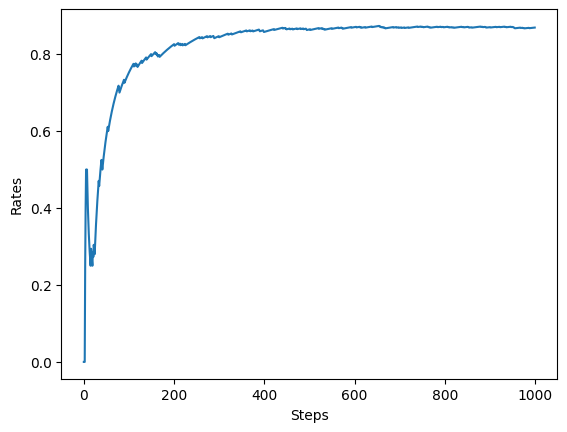

In [3]:
# bandit.py

import numpy as np
import matplotlib.pyplot as plt


class Bandit:
    def __init__(self, arms=10):  # arms = 슬롯머신 대수
        self.rates = np.random.rand(arms)  # 슬롯머신 각각의 승률 설정(무작위)

    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand():
            return 1
        else:
            return 0


class Agent:
    def __init__(self, epsilon, action_size=10):
        self.epsilon = epsilon  # 무작위로 행동할 확률(탐색 확률)
        self.Qs = np.zeros(action_size)
        self.ns = np.zeros(action_size)

    # 슬롯머신의 가치 추정
    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]

    # 행동 선택(ε-탐욕 정책)
    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))  # 무작위 행동 선택
        return np.argmax(self.Qs)  # 탐욕 행동 선택


if __name__ == '__main__':
    steps = 1000
    epsilon = 0.1

    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    total_rewards = []  # 보상 합
    rates = []          # 승률

    for step in range(steps):
        action = agent.get_action()   # 행동 선택
        reward = bandit.play(action)  # 실제로 플레이하고 보상을 받음
        agent.update(action, reward)  # 행동과 보상을 통해 학습
        total_reward += reward

        total_rewards.append(total_reward)       # 현재까지의 보상 합 저장
        rates.append(total_reward / (step + 1))  # 현재까지의 승률 저장

    print(total_reward)

    # [그림 1-12] 단계별 보상 총합
    plt.ylabel('Total reward')
    plt.xlabel('Steps')
    plt.plot(total_rewards)
    plt.show()

    # [그림 1-13] 단계별 승률
    plt.ylabel('Rates')
    plt.xlabel('Steps')
    plt.plot(rates)
    plt.show()


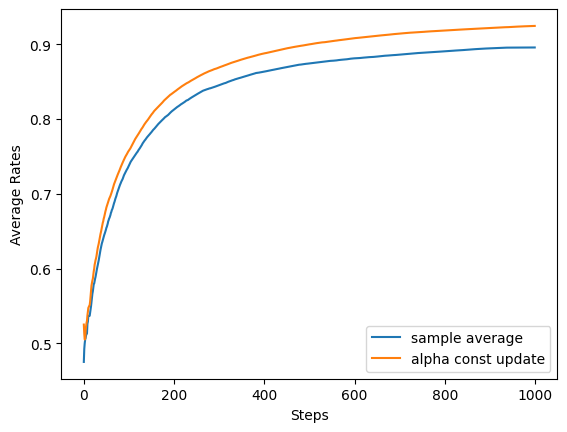

In [4]:
# non_stationary.py

import numpy as np
import matplotlib.pyplot as plt
from bandit import Agent


class NonStatBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms)

    def play(self, arm):
        rate = self.rates[arm]
        self.rates += 0.1 * np.random.randn(self.arms)  # 노이즈 추가
        if rate > np.random.rand():
            return 1
        else:
            return 0


class AlphaAgent:
    def __init__(self, epsilon, alpha, actions=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(actions)
        self.alpha = alpha  # 고정값 α

    def update(self, action, reward):
        # α로 갱신
        self.Qs[action] += (reward - self.Qs[action]) * self.alpha

    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        return np.argmax(self.Qs)


runs = 200
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ['sample average', 'alpha const update']
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))  # (200, 1000)

    for run in range(runs):
        if agent_type == 'sample average':
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(epsilon, alpha)

        bandit = NonStatBandit()
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

# [그림 1-20] 표본 평균과 고정값 α에 의한 갱신 비교
plt.figure()
plt.ylabel('Average Rates')
plt.xlabel('Steps')
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()
